In [1]:
import sys
import os
import time
import json


import numpy as np
import sklearn
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree

In [2]:
url = 'https://raw.githubusercontent.com/malogalbo/BasicTitanic/main/data/test.csv'
test_data = pd.read_csv(url, encoding='cp1252', index_col = 0, on_bad_lines = "skip")
url = 'https://raw.githubusercontent.com/malogalbo/BasicTitanic/main/data/train.csv'
train_data = pd.read_csv(url, encoding='cp1252', index_col = 0, on_bad_lines = "skip")
train_data.isna().sum()
train_data["Age"].fillna(train_data["Age"].mean(skipna = True), inplace = True)
test_data["Age"].fillna(test_data["Age"].mean(skipna = True), inplace = True)

train_data["Embarked"].fillna("S", inplace = True)
test_data["Embarked"].fillna("S", inplace = True)

test_data["Fare"].fillna(test_data["Fare"].mean(skipna = True), inplace = True)

test_ids = test_data.index.values

# Loading and Pre-Processing Data

In [3]:
def train_val_split(x, y, prop_vec, shuffle=True, seed=None):

    assert x.shape[0] == y.shape[0]
    prop_vec = prop_vec / np.sum(prop_vec) # normalize

    n = x.shape[0]
    n_train = int(np.ceil(n * prop_vec[0]))
    n_val = n - n_train

    assert np.amin([n_train, n_val]) >= 1   

    if shuffle:
        rng = np.random.default_rng(seed)
        pi = rng.permutation(n)
    else:
        pi = np.arange(0, n)

    pi_train = pi[0:n_train]
    pi_val = pi[n_train:n]

    train_x = x[pi_train]
    train_y = y[pi_train]

    val_x = x[pi_val]
    val_y = y[pi_val]  
    
    return train_x, train_y, val_x, val_y

One Hot Encode:
"Pclass" 3rd, "Embarked" 

From String to Bool:
"Sex" 5th

Normalize/Standardize
"Fare"
"Age"
"Parch"
"sibsp"


y-column:
"Survived" 2nd

In [4]:
#4,5,6 
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


In [5]:
#Drop Name, Cabin, Ticket
names = ['Name', 'Cabin', 'Ticket']
train_data = train_data.drop(columns=names, axis=1)
test_data = test_data.drop(columns=names, axis=1)
print(train_data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB
None


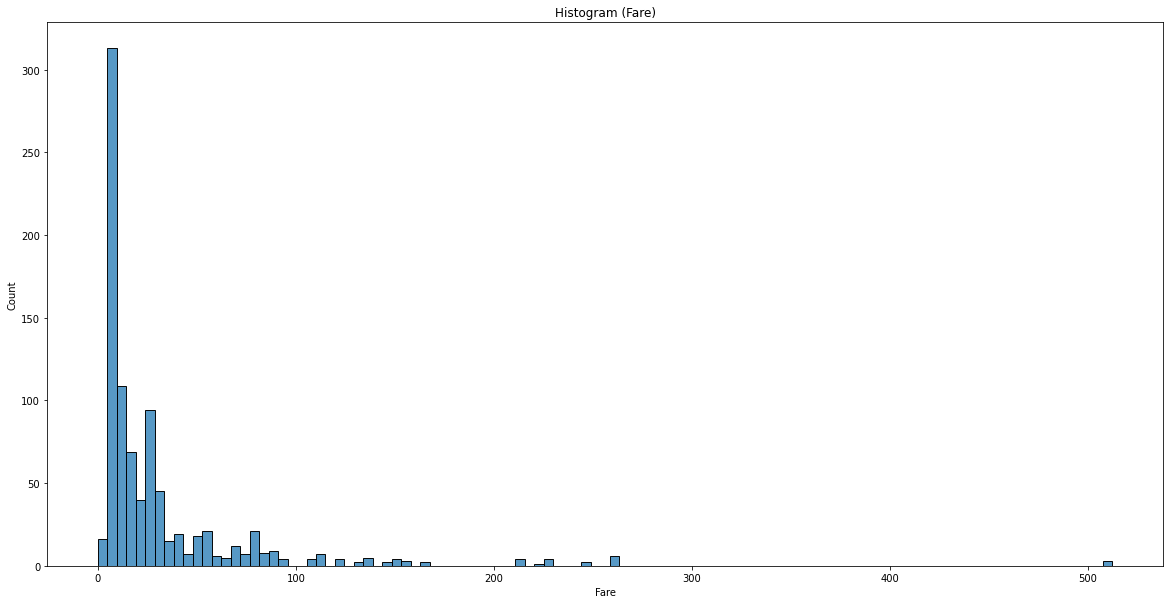

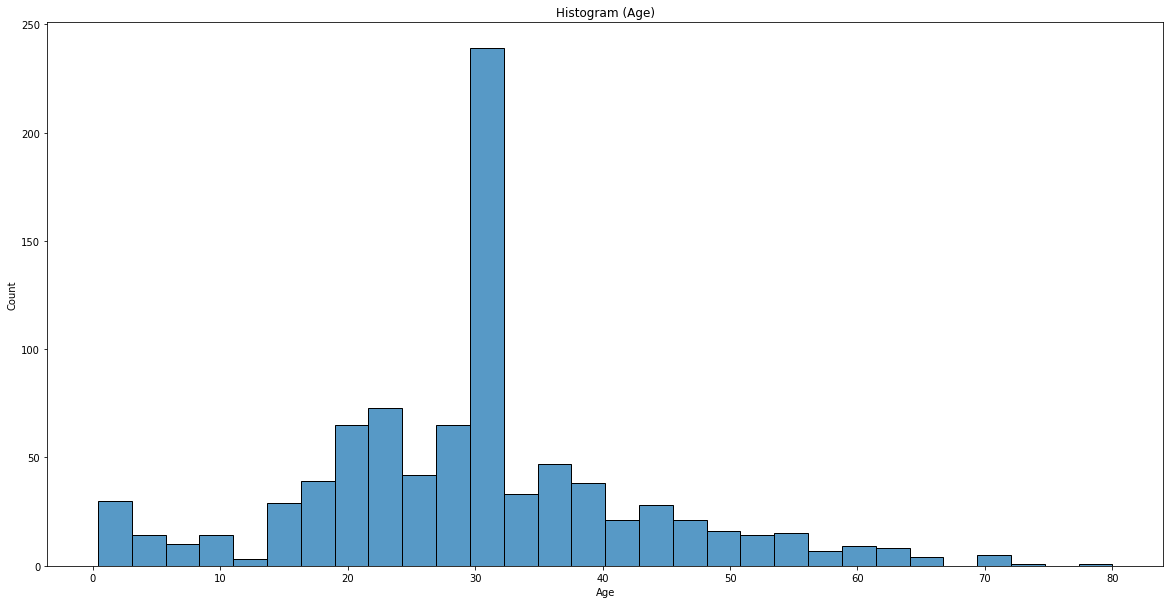

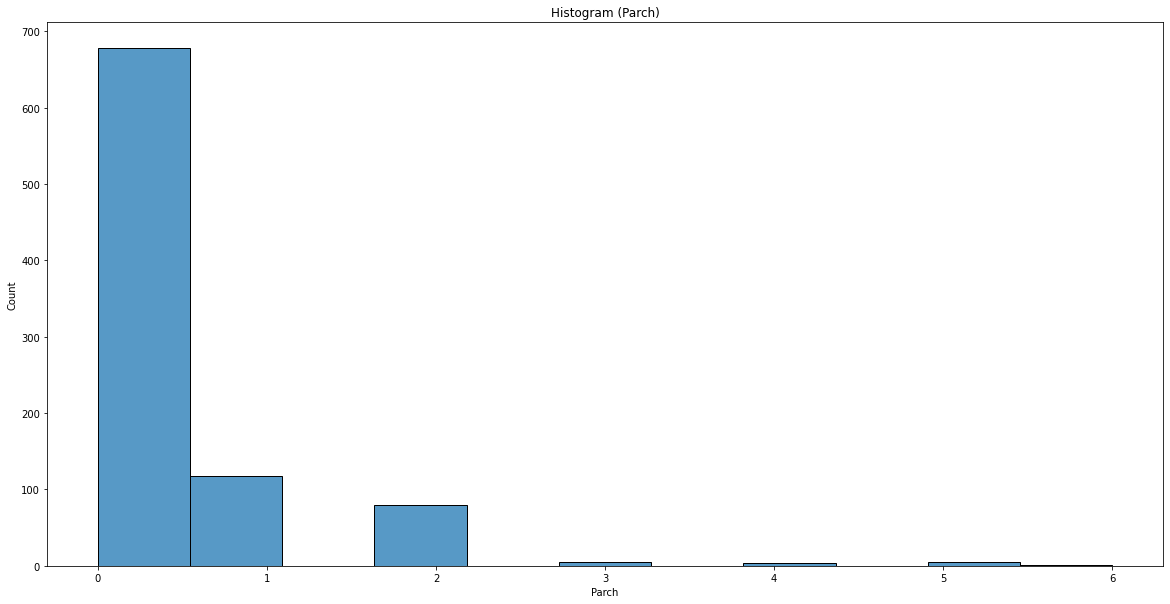

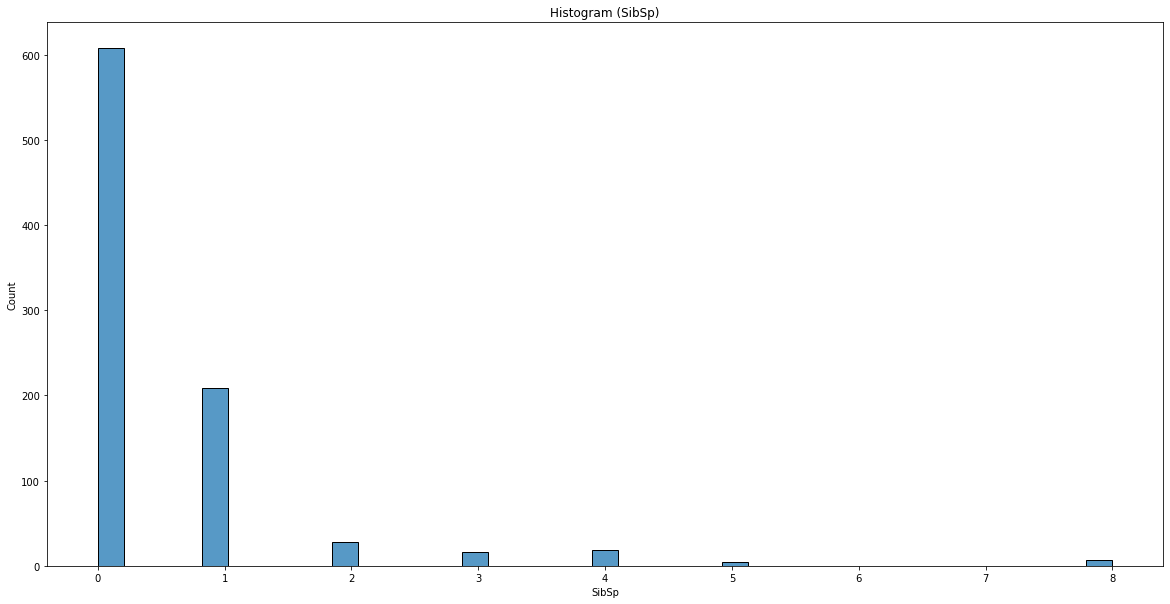

In [6]:
#Normalize/Standardize Fare , Age, Parch, Sibsp
names = ['Fare', 'Age', 'Parch', 'SibSp']
def plotHistogram(data, col):
    plt.figure(figsize = (20,10))
    sns.histplot(x = col, data = data)
    plt.title("Histogram (" + col + ")")
    plt.show()
for name in names:
    plotHistogram(train_data, name)

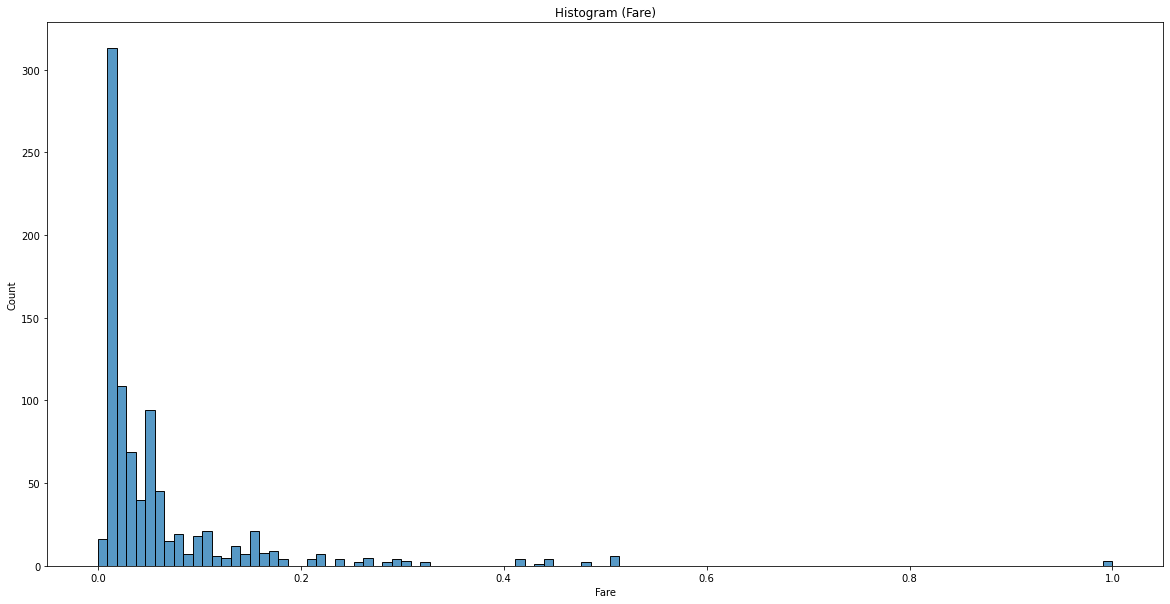

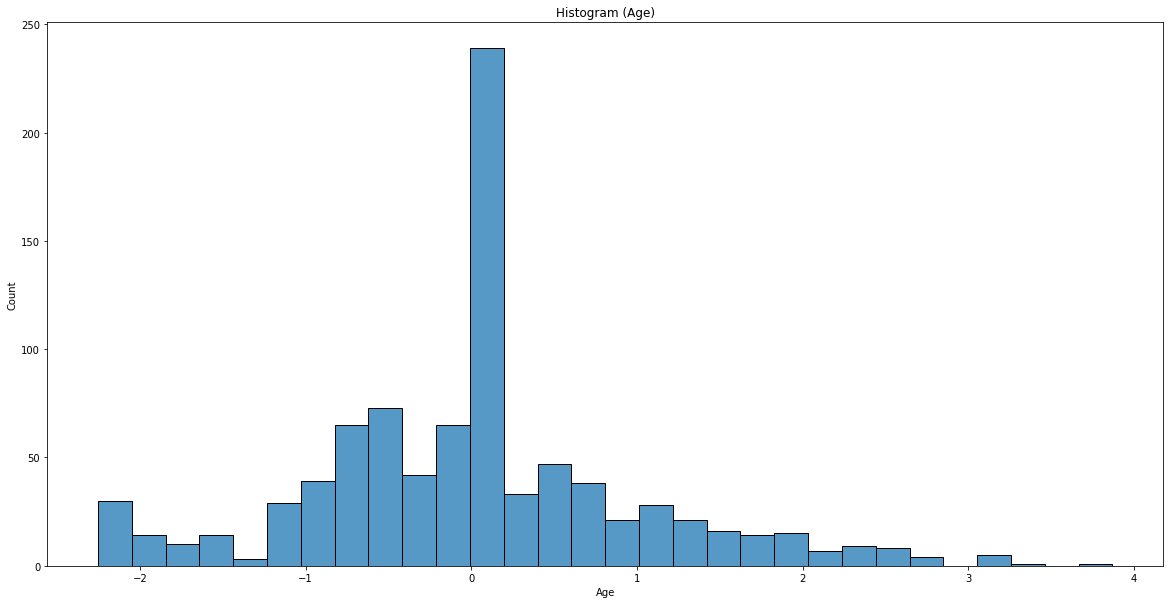

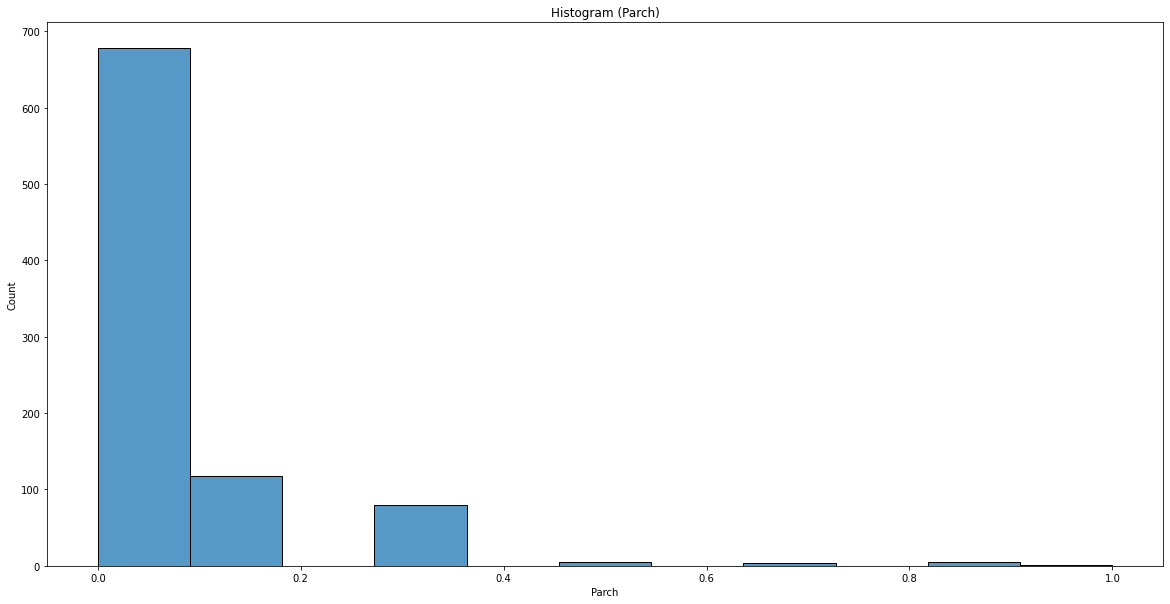

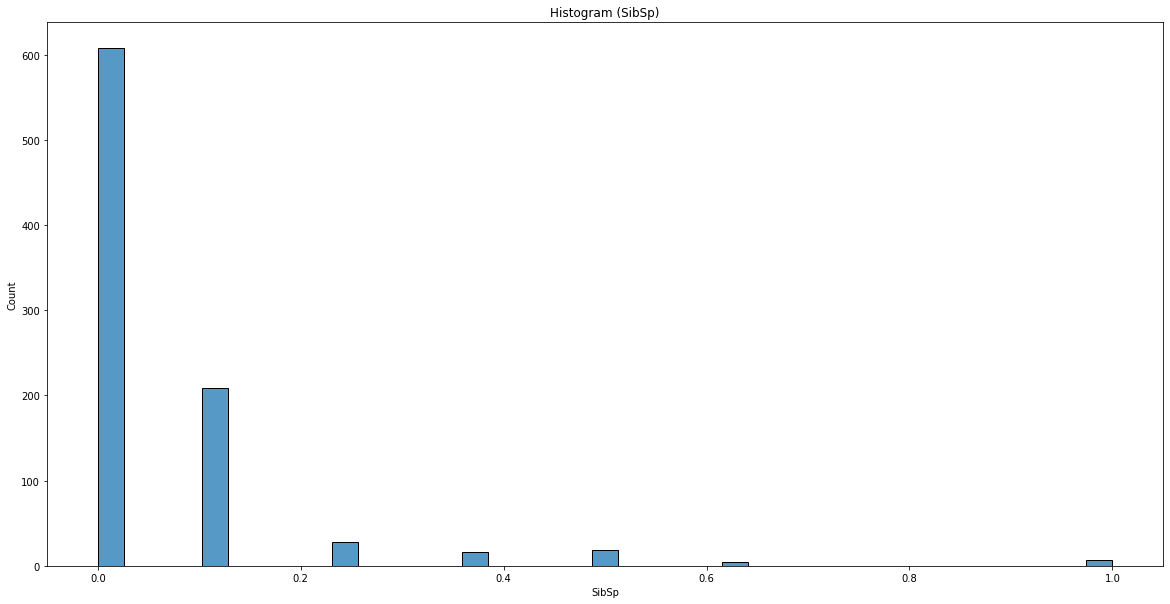

In [7]:
#Normalize: SibSp, Parch, Fare
#Standardize: Age
to_normalize = ['SibSp', 'Parch', 'Fare']
to_standardize = ['Age']
def normalize_standardize(data, norm, std):
    data[std] = StandardScaler().fit_transform(data[std])
    data[norm] = MinMaxScaler().fit_transform(data[norm])

normalize_standardize(train_data, to_normalize, to_standardize)
normalize_standardize(test_data, to_normalize, to_standardize)
for name in names:
    plotHistogram(train_data, name)


In [8]:
# Clean According To Above

# Extract y-column from training

# Then Split

In [9]:
#extract y
train_y = train_data.loc[:, "Survived"]
train_x = train_data.drop(columns=['Survived'], axis=1)

#no test y
test_x = test_data

print(train_y)

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64


In [10]:
test_x = test_x.to_numpy()
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()

In [11]:
print(train_x[0])
print(test_x[0])

[3 'male' -0.5924805998028931 0.125 0.0 0.014151057562208049 'S']
[3 'male' 34.5 0 0 7.8292 'Q']


In [12]:
#one hot encode categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

features_to_standardize = [0, 6] #pclass and embarked

#train_x
tmp = encoder.fit_transform(train_x[:, features_to_standardize]).toarray() #encode data

train_x = np.delete(train_x, features_to_standardize, 1) #delete all old cat columns, 1 for col
train_x = np.concatenate((train_x, tmp), axis = 1) #add encoded variables to train_x

#test_x
tmp = encoder.fit_transform(test_x[:, features_to_standardize]).toarray()

test_x = np.delete(test_x, features_to_standardize, 1) #delete all old cat columns, 1 for col
test_x = np.concatenate((test_x, tmp), axis = 1)

In [13]:
print(train_x[0])
print(test_x[0])

['male' -0.5924805998028931 0.125 0.0 0.014151057562208049 0.0 0.0 1.0 0.0
 0.0 1.0]
['male' 34.5 0 0 7.8292 0.0 0.0 1.0 0.0 1.0 0.0]


In [14]:
#convert sex from string to bool
for i, sex in enumerate(train_x.T[0]): 
    if (sex == "male"):
        train_x[i, 0] = 1
    else: 
        train_x[i, 0] = 0
for i, sex in enumerate(test_x.T[0]): 
    if (sex == "male"):
        test_x[i, 0] = 1
    else: 
        test_x[i, 0] = 0


In [15]:
prop_vec = [0.7, 0.3]

In [16]:
#split and get validation data
train_x, train_y, val_x, val_y = train_val_split(train_x, train_y, prop_vec, shuffle=True, seed=None)


In [17]:
print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(624, 11)
(267, 11)
(624,)
(267,)


In [18]:

decision_tree_model = DecisionTreeClassifier(random_state = 2)
decision_tree_model.fit(train_x.astype(float), train_y.astype(float))
y_pred = decision_tree_model.predict(train_x.astype(float))
decision_tree_model_acc = accuracy_score(y_pred.astype(float), train_y.astype(float)) * 100
print("Accuracy:", decision_tree_model_acc)

Accuracy: 99.19871794871796


In [19]:
random_forest_model = RandomForestClassifier(criterion='gini',
                                            n_estimators=2000,
                                            max_depth=7,
                                            min_samples_split=6,
                                            min_samples_leaf=6,
                                            max_features='auto',
                                            verbose=1,
                                            random_state = 3)
random_forest_model.fit(train_x, train_y)
y_pred = random_forest_model.predict(train_x)
random_forest_model_acc = accuracy_score(y_pred, train_y) * 100
print("Accuracy:", random_forest_model_acc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 86.53846153846155


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


In [20]:
y_pred = random_forest_model.predict(val_x)
random_forest_model_acc = accuracy_score(y_pred, val_y) * 100
print("Validation Accuracy:", random_forest_model_acc)

Validation Accuracy: 80.14981273408239


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


In [21]:
#KNN Mode

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=4, weights='distance', algorithm='kd_tree', p=1, metric='minkowski')
knn_model.fit(train_x, train_y)

train_y_pred = knn_model.predict(train_x)
val_y_pred = knn_model.predict(val_x)

knn_model_train_accuracy = accuracy_score(train_y_pred, train_y) * 100
knn_model_val_accuracy = accuracy_score(val_y_pred, val_y) * 100

print("KNN model training accuracy: ", knn_model_train_accuracy)
print("KNN model validation accuracy: ", knn_model_val_accuracy)

KNN model training accuracy:  99.19871794871796
KNN model validation accuracy:  79.40074906367042


SVM Below:

In [23]:
from sklearn.svm import SVC

svc_model = SVC(kernel = 'rbf').fit(train_x, train_y)

train_y_pred = svc_model.predict(train_x)
val_y_pred = svc_model.predict(val_x)

svc_model_train_accuracy = accuracy_score(train_y_pred, train_y) * 100
svc_model_val_accuracy = accuracy_score(val_y_pred, val_y) * 100

print("SVM model training accuracy: ", svc_model_train_accuracy)
print("SVM model validation accuracy: ", svc_model_val_accuracy)

SVM model training accuracy:  83.01282051282051
SVM model validation accuracy:  82.02247191011236


In [24]:
final_y_pred = svc_model.predict(test_x)

submission = pd.DataFrame({
    "PassengerId" : test_ids,
    "Survived" : final_y_pred
})

In [35]:
test_x[0:10]

array([[1, 34.5, 0, 0, 7.8292, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
       [0, 47.0, 1, 0, 7.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
       [1, 62.0, 0, 0, 9.6875, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
       [1, 27.0, 0, 0, 8.6625, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
       [0, 22.0, 1, 1, 12.2875, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
       [1, 14.0, 0, 0, 9.225, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
       [0, 30.0, 0, 0, 7.6292, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
       [1, 26.0, 1, 1, 29.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
       [0, 18.0, 0, 0, 7.2292, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
       [1, 21.0, 2, 0, 24.15, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]], dtype=object)

In [34]:
train_x[0:10]

array([[1, -0.5155262490625547, 0.0, 0.0, 0.020494635090094415, 0.0, 1.0,
        0.0, 0.0, 0.0, 1.0],
       [1, 0.40792595982150565, 0.0, 0.0, 0.020494635090094415, 0.0, 1.0,
        0.0, 0.0, 0.0, 1.0],
       [1, -0.20770884610120124, 0.0, 0.0, 0.015411575213749286, 0.0,
        0.0, 1.0, 0.0, 0.0, 1.0],
       [1, -0.5924805998028931, 0.0, 0.0, 0.014679623960531627, 0.0, 0.0,
        1.0, 0.0, 0.0, 1.0],
       [0, 1.0235607657442125, 0.0, 0.16666666666666666,
        0.41250332793836464, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
       [1, -0.361617547581878, 0.0, 0.0, 0.013760683560491965, 0.0, 0.0,
        1.0, 0.0, 0.0, 1.0],
       [1, 1.5622412209265812, 0.0, 0.0, 0.025374310111545468, 0.0, 1.0,
        0.0, 0.0, 0.0, 1.0],
       [0, -0.1307544953608629, 0.0, 0.0, 0.02469115560854232, 0.0, 1.0,
        0.0, 0.0, 0.0, 1.0],
       [1, -2.1315676146096605, 0.5, 0.16666666666666666,
        0.07746484096553544, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
       [1, -2.054613263869322, 0.5, 0.33333333

In [27]:
submission.to_csv('submission.csv', index = False)